## Making figure 5

Start by importing modules and data file, defining functions and priors.

In [20]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pylab as plt
import numpyro.distributions as dist
import numpy.random as rand
from scipy.stats import norm, uniform

from makeCorner import *

In [13]:
cdf_file = "../data/RUNS/power_law_only_high_sigmoids.cdf"
data = az.from_netcdf(cdf_file)
samps = data.posterior.stack(draws=("chain", "draw"))

In [21]:
def sigmoid_no_delta(low, high, width, middle, zs):
    return (high - low) / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

def computing_gaussian_prob(value, mean, std):
    return (1/(std * np.sqrt(2*np.pi))) * np.exp(-(value - mean)**2/(2.*std**2))

def computing_uniform_prob(a, b):
    return 1/(b-a)

zs = np.linspace(0,2,500)

### Computing prior samples

In [14]:
lambda_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(zs)))

prior_alpha_ref = rand.normal(-2,3, samps.alpha_ref.size)
prior_high_alpha = rand.normal(-2,3, samps.alpha_ref.size)
prior_width_alpha = rand.uniform(-1,1, samps.alpha_ref.size)
prior_middle_alpha = rand.uniform(0, 0.8, samps.alpha_ref.size)

for i in range(samps.alpha_ref.size):
    alpha_r = sigmoid_no_delta(prior_alpha_ref[i],
                               prior_high_alpha[i],
                               10.**prior_width_alpha[i],
                               prior_middle_alpha[i],
                               zs,
                              )
    lambda_matrix[i, :] = alpha_r

alpha_median = np.median(lambda_matrix, axis = 0)
only_prior_alpha_median = alpha_median
only_prior_alpha_quantile_5 = np.quantile(lambda_matrix,0.05,axis=0)
only_prior_alpha_quantile_95 = np.quantile(lambda_matrix,0.95,axis=0)

In [15]:
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

prior_fp = rand.uniform(-6,0, samps.alpha_ref.size)
prior_high_fp = rand.uniform(-6,0, samps.alpha_ref.size)
prior_width_fp = rand.uniform(-1,1, samps.alpha_ref.size)
prior_middle_fp = rand.uniform(0, 0.8, samps.alpha_ref.size)

for i in range(samps.log_f_peak.size):
    fp_r = sigmoid_no_delta(prior_fp[i],
                               prior_high_fp[i],
                               10.**prior_width_fp[i],
                               prior_middle_fp[i],
                               zs,
                              )
    fp_matrix[i, :] = fp_r

fp_median = np.median(fp_matrix, axis = 0)
only_prior_fp_median = fp_median
only_prior_fp_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
only_prior_fp_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)

In [16]:
mMin_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

prior_mMin = rand.uniform(5,15, samps.alpha_ref.size)
prior_high_mMin = rand.uniform(5,15, samps.alpha_ref.size)
prior_width_mMin = rand.uniform(-1,1, samps.alpha_ref.size)
prior_middle_mMin = rand.uniform(0, 0.8, samps.alpha_ref.size)

for i in range(samps.log_f_peak.size):
    mMin_r = sigmoid_no_delta(prior_mMin[i],
                               prior_high_mMin[i],
                               10.**prior_width_mMin[i],
                               prior_middle_mMin[i],
                               zs,
                              )
    mMin_matrix[i, :] = mMin_r

mMin_median = np.median(mMin_matrix, axis = 0)
only_prior_mMin_median = mMin_median
only_prior_mMin_quantile_5 = np.quantile(mMin_matrix,0.05,axis=0)
only_prior_mMin_quantile_95 = np.quantile(mMin_matrix,0.95,axis=0)

## Making figure 5

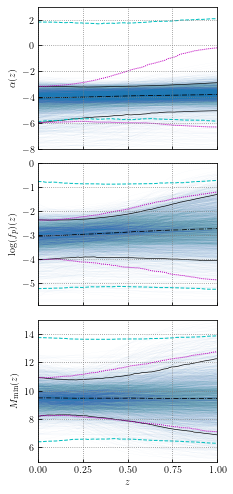

In [19]:
cm = 1/2.54
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8.75*cm, 3*5.9*cm))
zs = np.linspace(0,1,500)
z_ref = 0

ax1.set_rasterization_zorder(2)
alpha_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(zs)))
alpha_matrix_post = np.zeros((len(range(samps.alpha_ref.size)), len(zs)))
low_value_z_matrix = np.zeros(len(samps.alpha_ref.values))
for i in range(samps.alpha_ref.size):
    okay = False
    while not okay:
        prior_alpha = rand.normal(-2, 3)
        prior_high_alpha = rand.normal(-2, 3)
        prior_width_alpha = rand.uniform(-1,1)
        prior_width_non_log_alpha = 10.**prior_width_alpha
        prior_middle_alpha = rand.uniform(0, 0.8)
        posterior_value_z_0 = sigmoid_no_delta(samps.alpha_ref.values[i],
                               samps.high_alpha.values[i],
                               10.**samps.log_width_alpha.values[i],
                               samps.middle_z_alpha.values[i],
                               z_ref,
                              )
        intermediate_step = 1 + np.exp(samps.middle_z_alpha.values[i]/samps.width_alpha.values[i])
        value_at_z_0 = samps.alpha_ref.values[i] + (
            (samps.high_alpha.values[i] - samps.alpha_ref.values[i])/(intermediate_step)
        )
        intermediate_step_prior = np.exp(prior_middle_alpha/prior_width_non_log_alpha)
        low_z_value_alpha = (prior_high_alpha - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

        prob_low_prior = computing_gaussian_prob(low_z_value_alpha, -2, 3)
        exp_inv = 1 - (1/(1 + np.exp(-(z_ref - prior_middle_alpha)/prior_width_non_log_alpha)))
        C = 1 # 1e4
        rejection_param = prob_low_prior * exp_inv**(-1) / C
    
        rejection_threshold = rand.uniform(0, 1)

        if rejection_threshold <= rejection_param:
            okay = True

    alpha_r = sigmoid_no_delta(low_z_value_alpha,
                               prior_high_alpha,
                               10.**prior_width_alpha,
                               prior_middle_alpha,
                               zs,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    alpha_matrix[i, :] = alpha_r
    
    alpha_r_post = sigmoid_no_delta(samps.alpha_ref.values[i],
                               samps.high_alpha.values[i],
                               10.**samps.log_width_alpha.values[i],
                               samps.middle_z_alpha.values[i],
                               zs,
                              )
    ax1.plot(zs, alpha_r_post, lw = 0.05, color='#1f78b4', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.median(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
ax1.set_ylim(-8,3)
ax1.set_ylabel(r"$\alpha(z)$", fontsize = 10)
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(zs, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(zs,np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(zs,np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
# ax1.plot(zs, median_alpha, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax1.plot(zs,np.quantile(alpha_matrix,0.05,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
ax1.plot(zs,np.quantile(alpha_matrix,0.95,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
# ax1.plot(zs, only_prior_alpha_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(zs, only_prior_alpha_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(zs, only_prior_alpha_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")

ax2.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))
fp_matrix_post = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))
low_value_z_matrix = np.zeros(len(samps.log_f_peak.values))
for i in range(samps.log_f_peak.size):
    okay = False
    while not okay:
        prior_fpeak = rand.uniform(-6, 0)
        prior_high_fpeak = rand.uniform(-6, 0)
        prior_width_fpeak = rand.uniform(-1,1)
        prior_width_non_log_fpeak = 10.**prior_width_fpeak
        prior_middle_fpeak = rand.uniform(0, 0.8)
        posterior_value_z_0 = sigmoid_no_delta(samps.log_f_peak.values[i],
                               samps.log_high_f_peak.values[i],
                               10.**samps.log_width_f_peak.values[i],
                               samps.middle_z_f_peak.values[i],
                               0,
                              )

        intermediate_step = 1 + np.exp(samps.middle_z_f_peak.values[i]/samps.width_f_peak.values[i])
        value_at_z_0 = samps.log_f_peak.values[i] + (
            (samps.log_high_f_peak.values[i] - samps.log_f_peak.values[i])/(intermediate_step)
        )
        intermediate_step_prior = np.exp(prior_middle_fpeak/(10**(prior_width_fpeak)))
        low_z_value_fp = (prior_high_fpeak - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
    # posterior_value_z_0 - ( prior_high_fpeak - prior_fpeak ) / ( 1 + jnp.exp( prior_middle_fpeak / 10**prior_width_fpeak ) )

        low_value_z_matrix[i] = low_z_value_fp
        prob_low_prior = computing_uniform_prob(-6, 0)
        exp_inv = 1 - (1/(1 + np.exp(-(z_ref - prior_middle_fpeak)/prior_width_non_log_fpeak)))
        C = 1 # 1e4
        rejection_param = prob_low_prior * exp_inv**(-1) / C
    
        rejection_threshold = rand.uniform(0, 1)

        if rejection_threshold <= rejection_param:
            okay = True

    fp_r = sigmoid_no_delta(low_z_value_fp,
                               prior_high_fpeak,
                               10.**prior_width_fpeak,
                               prior_middle_fpeak,
                               zs,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = fp_r
    
    fp_r_post = sigmoid_no_delta(samps.log_f_peak.values[i],
                               samps.log_high_f_peak.values[i],
                               10.**samps.log_width_f_peak.values[i],
                               samps.middle_z_f_peak.values[i],
                               zs,
                              )
    ax2.plot(zs, fp_r_post, lw = 0.05, color='#1f78b4', alpha = 0.2, zorder = 1)
    fp_matrix_post[i, :] = fp_r_post

median_fp = np.median(fp_matrix, axis = 0)
median_fp_post = np.median(fp_matrix_post, axis = 0)
ax2.set_ylim(-5.9, 0)
ax2.set_ylabel(r"$\log(f_p)(z)$", fontsize = 10)
ax2.tick_params(axis='y', labelsize=10)
ax2.plot(zs, median_fp_post, "-.", c="k", zorder = 1, lw = 0.8)
ax2.plot(zs,np.quantile(fp_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(zs,np.quantile(fp_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
# ax2.plot(zs, median_fp, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax2.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
ax2.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
# ax2.plot(zs, only_prior_fp_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(zs, only_prior_fp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(zs, only_prior_fp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")


ax3.set_rasterization_zorder(2)
mMin_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))
mMin_matrix_post = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))
low_value_z_matrix = np.zeros(len(samps.log_f_peak.values))
for i in range(samps.log_f_peak.size):
    okay = False
    while not okay:
        prior_mMin = rand.uniform(5,15)
        prior_high_mMin = rand.uniform(5,15)
        prior_width_mMin = rand.uniform(-1,1)
        prior_middle_mMin = rand.uniform(0, 0.8)
        posterior_value_z_0 = sigmoid_no_delta(samps.mMin.values[i],
                               samps.high_mMin.values[i],
                               10.**samps.log_width_mMin.values[i],
                               samps.middle_z_mMin.values[i],
                               0,
                              )

        intermediate_step = 1 + np.exp(samps.middle_z_mMin.values[i]/samps.width_mMin.values[i])
        value_at_z_0 = samps.mMin.values[i] + (
            (samps.high_mMin.values[i] - samps.mMin.values[i])/(intermediate_step)
        )
        intermediate_step_prior = np.exp(prior_middle_mMin/(10**(prior_width_mMin)))
        low_z_value_mMin = (prior_high_mMin - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
        
        prob_low_prior = computing_uniform_prob(5, 15)
        exp_inv = 1 - (1/(1 + np.exp(-(z_ref - prior_middle_mMin)/10.**prior_width_mMin)))
        C = 1 # 1e4
        rejection_param = prob_low_prior * exp_inv**(-1) / C
    
        rejection_threshold = rand.uniform(0, 1)

        if rejection_threshold <= rejection_param:
            okay = True

    mMin_r = sigmoid_no_delta(low_z_value_mMin,
                               prior_high_mMin,
                               10.**prior_width_mMin,
                               prior_middle_mMin,
                               zs,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    mMin_matrix[i, :] = mMin_r
    
    mMin_r_post = sigmoid_no_delta(samps.mMin.values[i],
                               samps.high_mMin.values[i],
                               10.**samps.log_width_mMin.values[i],
                               samps.middle_z_mMin.values[i],
                               zs,
                              )
    ax3.plot(zs, mMin_r_post, lw = 0.05, color='#1f78b4', alpha = 0.2, zorder = 1)
    mMin_matrix_post[i, :] = mMin_r_post

median_mMin = np.median(mMin_matrix, axis = 0)
median_mMin_post = np.median(mMin_matrix_post, axis = 0)
ax3.set_xlim(0,1)
ax3.set_ylim(5, 15)
ax3.set_xlabel(r"$z$", fontsize = 10)
ax3.set_ylabel(r"$M_{\rm min}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax3.plot(zs, median_mMin_post, "-.", c="k", zorder = 1, lw = 0.8)
ax3.plot(zs,np.quantile(mMin_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax3.plot(zs,np.quantile(mMin_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
# 3.plot(zs, median_mMin, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax3.plot(zs,np.quantile(mMin_matrix,0.05,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
ax3.plot(zs,np.quantile(mMin_matrix,0.95,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
# ax3.plot(zs, only_prior_mMin_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax3.plot(zs, only_prior_mMin_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax3.plot(zs, only_prior_mMin_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")


plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

# Adjust layout
plt.tight_layout()
plt.savefig("Trace_conditional_prior_power_law.pdf", dpi=500, bbox_inches="tight")
plt.show()